In [1]:
#include("defArc.jl")

type Arc
    initNode::Int 
    termNode::Int 
    capacity::Float64
    freeflowtime::Float64
    flow::Float64
end

Arc(initNode::Int, termNode::Int, capacity::Float64, freeflowtime::Float64) = 
    Arc(initNode, termNode, capacity, freeflowtime, 0.)

Arc (constructor with 3 methods)

In [2]:
#include("fitTraffic.jl")

## Solve an inverse tarffic problem over polynomials 
## of degree at most d
## optionally use a regularizer from the poly kernel

using JuMP
using Gurobi
using Graphs
using Roots


polyEval(coeffs, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)])  

polyEval(coeffs::Array{Float64, 1}, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)]) 

bpacost(flow::Float64, capacity::Float64, freeflowtime::Float64) = freeflowtime*(1 + .15 * (flow/capacity)^4)
bpacost(flow::Float64, arc) = bpacost(flow, arc.capacity, arc.freeflowtime)
bpacost(arc::Arc) = bpacost(arc.flow, arc)

bpacost (generic function with 3 methods)

In [3]:
function setUpFitting(deg::Int, c::Float64)

	m = Model(solver=GurobiSolver(OutputFlag=false))
    
	@defVar(m, coeffs[1:deg+1])
	@defVar(m, Calphas[1:deg+1])

	#build the graham matrix; cf. Ref. [21] (Regularization Networks and Support Vector Machines), page 47
	samples = linspace(0, 1, deg + 1)
	k(x,y) = (c + x*y)^deg
	K = [ k(x,y) for x = samples, y=samples]
	K = convert(Array{Float64, 2}, K)
	assert(rank(K) == deg+1)
    
	C = chol(K + 1e-6* eye(deg+1))
	for i=1:deg + 1
		@addConstraint(m, polyEval(coeffs, samples[i]) == sum{C[j, i] * Calphas[j], j=1:deg+1})
	end
    
	@defVar(m, reg_term >= 0)
	reg_term_ = QuadExpr(Calphas[:], Calphas[:], ones(deg+1), AffExpr())
    
	@addConstraint(m, reg_term >= reg_term_)
    
	return m, coeffs, reg_term

end

setUpFitting (generic function with 1 method)

In [4]:
function fixCoeffs(m, fcoeffs, coeffs)
	for (fc, c) in zip(fcoeffs, coeffs[:])
		@addConstraint(m, fc == c)
	end
end

fixCoeffs (generic function with 1 method)

In [5]:
function addResid(m, coeffs, ys, demands, arcs, scaling)
	@defVar(m, resid)
	@defVar(m, dual_cost)
	@defVar(m, primal_cost)

	@addConstraint(m, dual_cost == sum{demands[(s,t)] * (ys[(s,t), t] - ys[(s,t), s]), (s,t)=keys(demands)})  
	@addConstraint(m, primal_cost == sum{a.flow * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})

	@addConstraint(m, resid >= (dual_cost - primal_cost) / scaling )
	@addConstraint(m, resid >= (primal_cost - dual_cost) / scaling )
	return resid
end

addResid (generic function with 1 method)

In [6]:
function addIncreasingCnsts(m, coeffs, arcs; TOL=0.)
	sorted_flows = sort([a.flow / a.capacity for a in values(arcs)])
	@addConstraint(m, polyEval(coeffs, 0) <= polyEval(coeffs, sorted_flows[1]))
	for i = 2:length(sorted_flows)
		@addConstraint(m, polyEval(coeffs, sorted_flows[i-1]) <= polyEval(coeffs, sorted_flows[i]) + TOL)
	end
end

addIncreasingCnsts (generic function with 1 method)

In [7]:
#equates the total cost of the network to the true total cost
function normalize(m, coeffs, tot_true_cost::Float64, arcs)
	@addConstraint(m, 
		sum{a.freeflowtime * a.flow * polyEval(coeffs, a.flow / a.capacity), a=values(arcs)} == tot_true_cost)
end

function normalize(m, coeffs, scaled_flow::Float64, cost::Float64)
	@addConstraint(m, polyEval(coeffs, scaled_flow) == cost)
end

function normalize(m, coeffs, scaled_flows::Array{Float64, 1}, avgCost::Float64)
    @addConstraint(m, sum{polyEval(coeffs, f), f=scaled_flows} == avgCost * length(scaled_flows))
end

normalize (generic function with 3 methods)

In [8]:
function addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
	@defVar(m, ys[keys(demands), 1:numNodes])
	for k = keys(arcs)
		a = arcs[k]
		rhs = a.freeflowtime * polyEval(coeffs, a.flow/a.capacity)
		for od in keys(demands)
			@addConstraint(m, ys[od, k[2]] - ys[od, k[1]] <= rhs)
		end
	end
	return ys
end

addNetworkCnsts (generic function with 1 method)

In [36]:
############
#Read in demand data
file = open("../temp_files/OD_demand_matrix_Jan_weekday_AM.txt")
demands = Dict{(Int64,Int64), Float64}()
n = 8  # number of nodes
for i in [1:n]
    demands[(i,i)] = 0.0
end
for line in eachline(file)
    OD_demand = split(line, ",")
    key, value = (int(OD_demand[1]),int(OD_demand[2])), float(split(OD_demand[3], "\n")[1])
    demands[key] = value
end
close(file)

In [37]:
demands

Dict{(Int64,Int64),Float64} with 64 entries:
  (3,6) => 266530.167897
  (4,4) => 0.0
  (3,1) => 3.5e-5
  (4,5) => 0.0
  (2,4) => 325875.079078
  (6,5) => 118577.044728
  (8,4) => 68657.636628
  (1,2) => 0.0
  (5,1) => 37070.553042
  (3,4) => 2.0e-6
  (8,2) => 6.9e-5
  (2,3) => 0.0
  (2,6) => 0.0
  (5,4) => 0.000265
  (2,1) => 313908.350923
  (2,5) => 0.0
  (8,5) => 1.8e-5
  (1,4) => 17298.036245
  (2,8) => 0.0
  (5,8) => 78721.24468
  (4,8) => 124634.188241
  (7,8) => 2.0e-6
  (1,1) => 0.0
  (7,7) => 0.0
  (5,7) => 99150.358181
  ⋮      => ⋮

In [38]:
using JSON

link_day_minute_Jan_dict = readall("../temp_files/link_day_minute_Jan_dict_JSON.json");
link_day_minute_Jan_dict = replace(link_day_minute_Jan_dict, "NaN", 0);

link_day_minute_Jan_dict = JSON.parse(link_day_minute_Jan_dict);

In [39]:
week_day_Jan_list = [2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 30, 31]

arcs = Dict{(Int, Int), Arc}[]
for j in week_day_Jan_list
    arcs_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Jan_dict[key]["init_node"]
        termNode = link_day_minute_Jan_dict[key]["term_node"]
        capacity = link_day_minute_Jan_dict[key]["MD_capac"]
        freeflowtime = link_day_minute_Jan_dict[key]["free_flow_time"]
        flow = link_day_minute_Jan_dict[key]["MD_flow"]
        arcs_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs, arcs_)
end

In [40]:
arcs[1]

Dict{(Int64,Int64),Arc} with 24 entries:
  (3,6) => Arc(3,6,1.1419e6,10.104091401583059,714707.0806914163)
  (2,3) => Arc(2,3,376200.0,6.245983825838077,304786.77474957914)
  (5,6) => Arc(5,6,361712.5,7.596735314731068,307666.31991436996)
  (5,4) => Arc(5,4,227525.0,10.879908330347215,184149.7550433264)
  (2,1) => Arc(2,1,790400.0,14.345919651016688,672444.1599475116)
  (6,3) => Arc(6,3,926250.0,10.755524605163453,631029.0704375401)
  (3,1) => Arc(3,1,1.5238e6,20.553379146316544,1.2581570289598794e6)
  (1,3) => Arc(1,3,1.4383e6,20.136411020613906,1.2112025079435855e6)
  (4,5) => Arc(4,5,218025.0,10.653322572942127,178134.2566708539)
  (4,8) => Arc(4,8,484500.0,15.071063131308403,408966.89862605464)
  (7,5) => Arc(7,5,708462.5,8.16675272101653,581236.1703636566)
  (8,7) => Arc(8,7,313500.0,8.841103424391747,265580.8736373477)
  (3,2) => Arc(3,2,471200.0,7.409576285430038,385761.8075304628)
  (7,6) => Arc(7,6,1.19129999999e6,11.056227551715708,1.003622065130695e6)
  (2,4) => Arc(2,4,9405

In [41]:
arcs[2]

Dict{(Int64,Int64),Arc} with 24 entries:
  (3,6) => Arc(3,6,1.1419e6,10.104091401583059,721888.5804166333)
  (2,3) => Arc(2,3,376200.0,6.245983825838077,309596.593666466)
  (5,6) => Arc(5,6,361712.5,7.596735314731068,301802.1472655671)
  (5,4) => Arc(5,4,227525.0,10.879908330347215,187747.12425283183)
  (2,1) => Arc(2,1,790400.0,14.345919651016688,663861.3445866527)
  (6,3) => Arc(6,3,926250.0,10.755524605163453,635720.3356163831)
  (3,1) => Arc(3,1,1.5238e6,20.553379146316544,1.243144259012138e6)
  (1,3) => Arc(1,3,1.4383e6,20.136411020613906,1.1782132034657327e6)
  (4,5) => Arc(4,5,218025.0,10.653322572942127,177207.05511917875)
  (4,8) => Arc(4,8,484500.0,15.071063131308403,407855.2407157393)
  (7,5) => Arc(7,5,708462.5,8.16675272101653,585405.7893072106)
  (8,7) => Arc(8,7,313500.0,8.841103424391747,258670.88700968405)
  (3,2) => Arc(3,2,471200.0,7.409576285430038,391496.6124684932)
  (7,6) => Arc(7,6,1.19129999999e6,11.056227551715708,1.019259894533683e6)
  (2,4) => Arc(2,4,940500

In [42]:
##########
# Set up demand data and flow data
##########
numData = length(arcs); 
sigma = .0

flow_data = Array(Float64, length(arcs[1]), numData)

demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs[1])
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end


for iRun = 1:numData
    for odpair in keys(demands)
        if ! haskey(demand_data, odpair)
            demand_data[odpair] = [demands[odpair], ]
        else
            push!(demand_data[odpair], demands[odpair])
        end
    end

    #flow_data[:, iRun] = [a.flow::Float64 for a in vArcs]
    flow_data[:, iRun] = [a.flow::Float64 for a in values(arcs[iRun])]
end

In [43]:
demand_data

Dict{(Int64,Int64),Array{Float64,1}} with 64 entries:
  (3,6) => [266530.167897,266530.167897,266530.167897,266530.167897,266530.16789…
  (4,4) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…
  (3,1) => [3.5e-5,3.5e-5,3.5e-5,3.5e-5,3.5e-5,3.5e-5,3.5e-5,3.5e-5,3.5e-5,3.5e-…
  (4,5) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…
  (2,4) => [325875.079078,325875.079078,325875.079078,325875.079078,325875.07907…
  (6,5) => [118577.044728,118577.044728,118577.044728,118577.044728,118577.04472…
  (8,4) => [68657.636628,68657.636628,68657.636628,68657.636628,68657.636628,686…
  (1,2) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…
  (5,1) => [37070.553042,37070.553042,37070.553042,37070.553042,37070.553042,370…
  (3,4) => [2.0e-6,2.0e-6,2.0e-6,2.0e-6,2.0e-6,2.0e-6,2.0e-6,2.0e-6,2.0e-6,2.0e-…
  (8,2) => [6.9e-5,6.9e-5,6.9e-5,6.9e-5,6.9e-5,6.9e-5,6.9e-5,6.9e-5,6.9e-5,6.9e-…
  (2,3) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [44]:
##########
#Fitting Funcs
##########

function train(indices, lam::Float64, deg::Int, c::Float64, demand_data, flow_data, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c)
    
    addIncreasingCnsts(m, coeffs, arcs, TOL=1e-8)  #uses the original obs flows

    avgCost = mean( [bpacost(a.flow, a.capacity, 1.0) for a in values(arcs)] )
    normalize(m, coeffs, [a.flow / a.capacity for a in values(arcs)], avgCost)


    resids = Variable[]
    
    for i = indices
        #copy the flow data over to the arcs, demand data to demands (slow)
        for (ix, a) in enumerate(vArcs)
            a.flow = flow_data[ix, i]
        end
        for odpair in keys(demands)
            demands[odpair] = demand_data[odpair][i]
        end
    
        #Dual Feasibility
        ys = addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
        
        #add the residual for this data point
        push!(resids, addResid(m, coeffs, ys, demands, arcs, 1e6))
    end

    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} + lam*reg_term)
    solve(m)
    println(getObjectiveValue(m) - lam * getValue(reg_term) )
    return [getValue(coeffs[i]) for i =1:length(coeffs)]
end

train (generic function with 1 method)

In [45]:
#include("trafficCval.jl")

arcs6 = arcs[1]
arcs7 = arcs[1]
arcs8 = arcs[1]
arcs9 = arcs[1]
coeffs_dict = Dict{(Int64,Float64,Float64),Array{Float64,1}}()

# deg = 6
deg = 6
c = 1.
lam = 1e1

fcoeffs6 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs6)
coeffs_dict[(deg, c, lam)] = fcoeffs6

# deg = 7
deg = 7
c = 1.
lam = 1e1

fcoeffs7 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs7)
coeffs_dict[(deg, c, lam)] = fcoeffs7

# deg = 8
deg = 8
c = 1.
lam = 5.

fcoeffs8 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs8)
coeffs_dict[(deg, c, lam)] = fcoeffs8

# deg = 9
deg = 9
c = 1.
lam = 5.

fcoeffs9 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs9)
coeffs_dict[(deg, c, lam)] = fcoeffs9

2859.4537261203545
2863.5686465376994
2863.316584577793
2863.161003991405


10-element Array{Float64,1}:
   0.497476 
   1.23513  
  -0.0146395
   1.8712   
 -15.8339   
  42.2575   
 -68.2167   
  67.5253   
 -36.2802   
   8.05201  

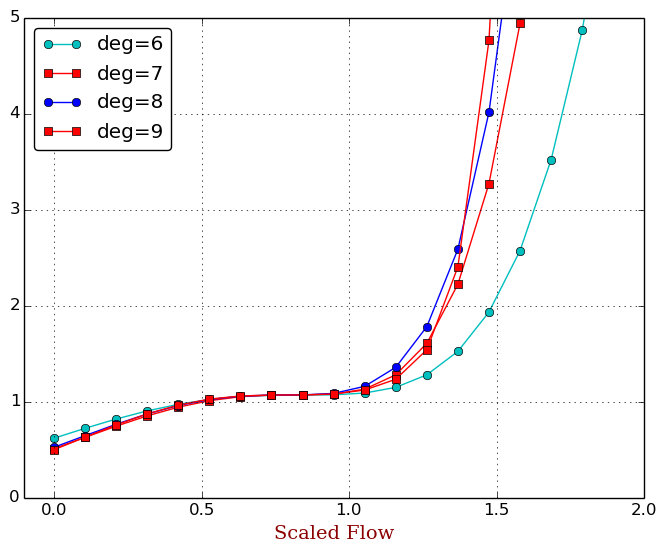

In [46]:
using PyPlot

#true_coeffs = [1, 0, 0, 0, .15]
fcoeffs6 = coeffs_dict[(6, 1., 1e1)]
fcoeffs7 = coeffs_dict[(7, 1., 1e1)]
fcoeffs8 = coeffs_dict[(8, 1., 5.)]
fcoeffs9 = coeffs_dict[(9, 1., 5.)]

xs = linspace(0, 2, 20)
#ys_true = map(x->polyEval(true_coeffs, x), xs)
ys6 = map(x->polyEval(fcoeffs6, x), xs)
ys7 = map(x->polyEval(fcoeffs7, x), xs)
ys8 = map(x->polyEval(fcoeffs8, x), xs)
ys9 = map(x->polyEval(fcoeffs9, x), xs)

# ys = map(x->polyEval(fcoeffs, x), xs)

#plot(xs, ys_true, "k", label="True")
plot(xs, ys6, "o-c", label="deg=6")
plot(xs, ys7, "s-r", label="deg=7")
plot(xs, ys8, "o-b", label="deg=8")
plot(xs, ys9, "s-r", label="deg=9")
legend(loc="upper left",fancybox="true") 
# plot(xs, ys, "--b")
grid("on")
xlim(-0.1, 2.0);
ylim(0.0, 5.0);

font1 = ["family"=>"serif",
    "color"=>"darkred",
    "weight"=>"normal",
    "size"=>14]
xlabel("Scaled Flow", fontdict=font1)

savefig("../temp_files/fitting_Jan_MD.pdf")

In [81]:
fcoeffs8, fcoeffs9

([0.522622,1.13609,0.306534,-1.56179,1.49191,-3.80528,5.20807,-2.92031,0.732637],[0.497476,1.23513,-0.0146395,1.8712,-15.8339,42.2575,-68.2167,67.5253,-36.2802,8.05201])

In [83]:
s = "{\"fcoeffs8\": $(fcoeffs8), \"fcoeffs9\": $(fcoeffs9)}"

outfile = open("../temp_files/fcoeffs_Jan_MD.json", "w")

JSON.print(outfile, s)

close(outfile)

In [84]:
fcoeffs_Jan_MD = readall("../temp_files/fcoeffs_Jan_MD.json")
fcoeffs_Jan_MD = JSON.parse(JSON.parse(fcoeffs_Jan_MD))

Dict{String,Any} with 2 entries:
  "fcoeffs8" => {0.5226215924685214,1.1360932831203272,0.30653366315081604,-1.56…
  "fcoeffs9" => {0.49747558208852927,1.2351262865802421,-0.014639493710369805,1.…